# How to use the CCS_fit module to fit two-body interactions

## Generate training data
Curvature Constrained Splines can be fitted to two-body interactions, based on the energies (and optionally forces) of pre-calculated structures. The to-be-fitted two-body interactions are given as input to the CCS_fit module in the form of a structures.json file, which will be generated below based on ASE (Atomic Simulation Environment) databases. ASE users might already be familiar with generating such databases, and are encouraged to use their own in the remainder of this tutorial. For those less familiar with ASE databases, the first step in this tutorial will generate such databases from VASP and DFTB calculations.

### (Optional) Build ASE database(s)
A training-set can be conveniently collected in an ASE database. In the case of DFTB repulsive fitting we can make two separate databases, one with the DFT-data and one with corresponding DFTB-data. The database(s) will contain forces and energies. A list ('file_list') specifying the folders where the DFT (and DFTB) outputs are stored should be provided. In the case of DFTB repulsive fitting each line of 'file_list' should contain two columns, the first giving the location of the DFT data and the second the corresponding DFTB data. At the moment, DFT output is assumed to be in the form of a VASP 'OUTCAR'-file, and the DFTB data in the form of a 'detailed.out' file. 

In [2]:
from ccs_fit.scripts.ccs_build_db import ccs_build_db as ccs_build_db

ccs_build_db(mode='DFTB', DFT_DB='Input_files/DFT.db', DFTB_DB='Input_files/DFTB.db', file_list='Input_files/trainset.list')

100%|█████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 20.43it/s]


In [4]:
# One can use the following ase commands to inspect the databases
!ase db Input_files/DFT.db
!ase gui Input_files/DFTB.db

id|age|formula|calculator|  energy|natoms| fmax|pbc|  volume|charge|   mass| smax
 1|17s|Si32   |unknown   |-142.214|    32|0.393|TTT|2199.839| 0.000|898.720|0.066
 2|17s|Si32   |unknown   |-146.004|    32|0.085|TTT|2873.267| 0.000|898.720|0.021
 3|17s|Si32   |unknown   |-140.007|    32|0.013|TTT|3117.690| 0.000|898.720|0.030
Rows: 3
Keys: PBE, key


Traceback (most recent call last):
  File "C:\Users\thism292\Anaconda3\envs\CCS_fit\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\thism292\Anaconda3\envs\CCS_fit\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\thism292\Anaconda3\envs\CCS_fit\lib\site-packages\ase\gui\pipe.py", line 32, in <module>
    main()
  File "C:\Users\thism292\Anaconda3\envs\CCS_fit\lib\site-packages\ase\gui\pipe.py", line 28, in main
    plt.show()
  File "C:\Users\thism292\Anaconda3\envs\CCS_fit\lib\site-packages\matplotlib\pyplot.py", line 421, in show
    return _get_backend_mod().show(*args, **kwargs)
  File "C:\Users\thism292\Anaconda3\envs\CCS_fit\lib\site-packages\matplotlib_inline\backend_inline.py", line 90, in show
    display(
  File "C:\Users\thism292\Anaconda3\envs\CCS_fit\lib\site-packages\IPython\core\display_functions.py", line 265, in display
    print(*objs)
ValueError: I/O operation on closed f

### Generate the CCS_fit input file; structures.json
The next commands fetch the training-set data from an ASE database containing NaCl structures and the corresponding energies based on a Lennard Jones potential.
Optionally, one could use the two ase databases that could have been generated in the previous section, DFT.db and DFTB.db, containing the databases contain forces and energies from a set of DFT and DFTB calculations. The previous optional section shows how to build such databases from a set of calculations.

In [1]:
import os
from ccs_fit import ccs_fetch

base_dir=os.getcwd()
os.chdir(base_dir + "/CCS/")

ccs_fetch(mode='CCS', R_c=6.0, Ns='all', DFT_DB='../Input_files/LJ.db') #, DFTB_DB='Input_files/DFTB.db')
# ccs_fetch(mode='CCS', R_c=6.0, Ns='all', DFT_DB='Input_files/DFT.db', DFTB_DB='Input_files/DFTB.db')

os.chdir(base_dir)

100%|██████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 420.93it/s]


## Fit training data to Curvature Constrained Splines
Finally, the splines are fitted to the target defined in the structures.json input file. The splines can be restricted to be fully repulsive ("rep"), or have a turning point/switch ("sw"), which is defined by the "Swtype" key.
ADD MORE INFO ON THE INPUT FILES

In [2]:
### Generate input.json file
import json

os.chdir(base_dir + "/CCS/")

input={
    "General": {
        "interface": "CCS"
    },
    "Twobody": {
                "Xx-Xx": {
                        "Rcut": 5.0,
                        "Resolution": 0.05,
                        "Swtype": "rep"
                },
                "Cl-Na": {
                        "Rcut": 5.0,
                        "Resolution": 0.05,
                        "Swtype": "sw"
                }
        }
}
#SAVE TO FILE
with open('input.json', 'w') as f:
    json.dump(input, f, indent=8)
    
os.chdir(base_dir)

In [3]:
#RUN FIT
from ccs_fit import ccs_fit

os.chdir(base_dir + "/CCS")

ccs_fit("input.json")

os.chdir(base_dir)

Generating one-body information from training-set.
    Added elements:  ['Cl', 'Na']
Generating two-body potentials from one-body information.
    Adding pair: Cl-Cl
    Adding pair: Na-Na
    Applying monotonous constraints for pair:  Cl-Na
    Applying monotonous constraints for pair:  Cl-Cl
    Applying monotonous constraints for pair:  Na-Na
There is linear dependence in stochiometry matrix!
    removing onebody term: Na


Finding optimum switch: 100%|███████████████████████████████████████████| 81/81 [00:02<00:00, 28.81it/s]


## Validate the performance of the splines

In [4]:
import ase.db as db
from tqdm import tqdm
from ccs_fit.ase_calculator.ccs_ase_calculator import CCS

os.chdir(base_dir + "/CCS")

LJ_DB=db.connect("../Input_files/LJ.db")
CCS_DB=db.connect("CCS.db")

with open('CCS_params.json', 'r') as f:
    CCS_params = json.load(f)

for row in tqdm(LJ_DB.select(), total=len(LJ_DB)):  
    structure=row.toatoms()
    structure.calc=CCS(CCS_params=CCS_params)
    structure.get_potential_energy()
    structure.get_forces()
    CCS_DB.write(structure,key=row.key,CCS=True)

os.chdir(base_dir)

  0%|                                                                            | 0/45 [00:00<?, ?it/s]C:\Users\thism292\Anaconda3\envs\CCS_fit\lib\site-packages\ase\utils\__init__.py:62: FutureWarning: Please use atoms.cell.rank instead
  warnings.warn(warning)
C:\Users\thism292\Anaconda3\envs\CCS_fit\lib\site-packages\ase\db\core.py:105: UserWarning: It is best not to use keys (CCS) that are also a chemical formula.  If you do a "db.select('CCS')",you will not find rows with your key.  Instead, you wil get rows containing the atoms in the formula!
  warnings.warn(
100%|███████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 54.74it/s]


In [5]:
#Read Data

epred=[];eref=[];

for row in tqdm(LJ_DB.select(), total=len(LJ_DB)):
    structure=row.toatoms()
    natoms=len(structure.get_atomic_numbers())
    id=str(row.key)
    epred.append(CCS_DB.get('key='+id).energy/natoms)
    eref.append(LJ_DB.get('key='+id).energy/natoms) 
    # edftb_css.append(db_dftb.get('key='+id).energy/natoms + db_ccs.get('key='+id).energy/natoms)

100%|██████████████████████████████████████████████████████████████████| 45/45 [00:00<00:00, 263.85it/s]


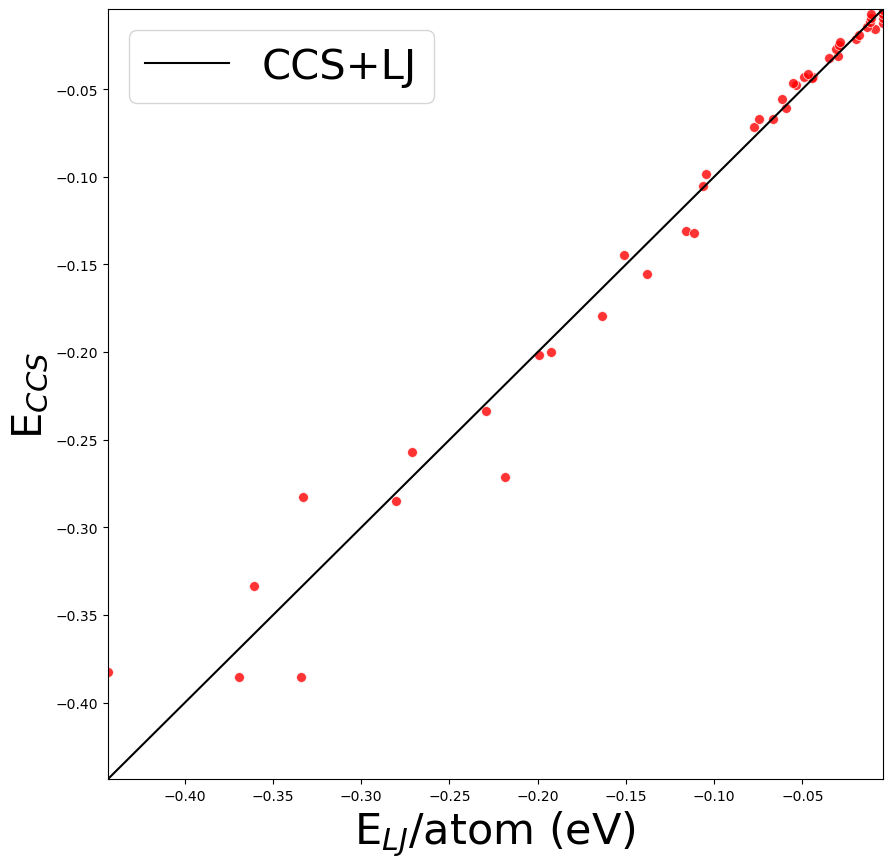

In [6]:
#plot Energies

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

df_plt = pd.DataFrame({"A":eref, "B":epred})
# print(df_plt)

plt.figure(figsize = (10,10))
plt.plot([np.min(eref),np.max(eref)], [np.min(eref),np.max(eref)], 'k-', lw=1.5)
sns.scatterplot(df_plt, x='A', y='B', s=50, alpha=0.8, color='r')
plt.legend(labels=["CCS+LJ"], fontsize=30 )
plt.xlabel('E$_{LJ}$/atom (eV)',fontsize=31)
plt.ylabel('E$_{CCS}$',fontsize=30)
plt.xlim(np.min(eref),np.max(eref))
plt.ylim(np.min(eref),np.max(eref))
# plt.savefig('DFTvsDFTB+CCS.png')
plt.show()

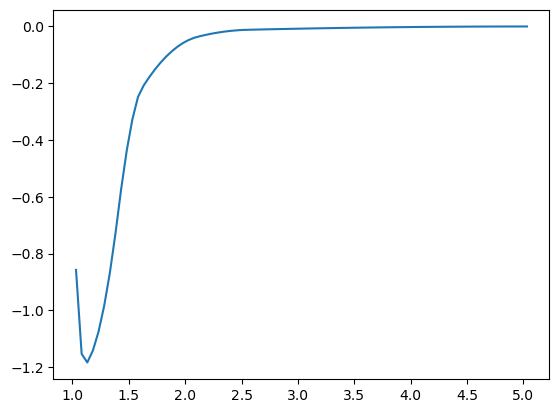

In [9]:
# Plot the Na-Cl interaction

plt.plot(CCS_params["Two_body"]["Cl-Na"]["r"], CCS_params["Two_body"]["Cl-Na"]["spl_a"])